In [1]:
import wfdb
import pdb
import os
import glob
import numpy as np
import csv
import pandas as pd
from scipy.signal import resample, butter, filtfilt, iirnotch
from catboost import CatBoost, CatBoostClassifier
import neurokit2 as nk
import ray
import keras
import copy
import gc
import plotly.graph_objects as go
%run useful_functions/sqis.ipynb

2024-10-03 18:14:02.505027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 18:14:02.728722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 18:14:02.763846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 18:14:02.991590: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 18:14:04.263605: W tensorflow/compiler/tf2

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1727990049.077822   10354 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727990049.550553   10354 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727990049.550860   10354 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
ray.init(ignore_reinit_error=True)

2024-10-02 16:17:11,939	INFO worker.py:1783 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.35.0


# Loading the TiDE Classifier Model

In [4]:
model_path = "/home/gabrielsaores/Documents/backup_pc_corrompido/ECG Quality/_weights_model.keras"
tide_model = keras.saving.load_model(model_path)

I0000 00:00:1727862499.718924    2456 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727862499.720077    2456 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727862499.720397    2456 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727862499.811358    2456 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## Using TiDE Classifier to select signals from MIMIC IV

In [5]:
sf = 500
new_sf = 125

@ray.remote
def process_file_chunk(file_chunk, tide_model, threshold, new_sf, sf):
    clean_records = []  # Create a local list to store clean records
    predictions = []  # Create a local list to store valid predictions
    print("enter")

    for file_path in file_chunk:
        if len(clean_records) % 5000 == 0:
            print(len(clean_records))

        record_name = os.path.splitext(file_path)[0]
        record = wfdb.rdrecord(record_name)

        content = record.p_signal[:, 1]
        
        ecg = resample(content, int(len(content) * new_sf / sf))

        # Make predictions
        prediction = tide_model.predict(ecg.reshape(1,-1), verbose=0)

        # Handle scalar or array predictions
        if np.isscalar(prediction):
            prediction_value = prediction
            print(prediction_value)
        else:
            prediction_value = prediction[0][0]

        # Apply threshold to the probability
        if prediction_value > threshold:
            predictions.append(prediction_value)                
            clean_records.append(ecg)

    return clean_records, np.array(predictions)  # Return the local clean records and predictions


def read_dat_files_parallel(directory, tide_model, threshold=0.9999):
    dat_files = glob.glob(os.path.join(directory, '**', '*.dat'), recursive=True)
    dat_files = list(set(dat_files))  # Ensure no duplicate files

    # Split the list of files into chunks for parallel processing
    num_chunks = 10  # You can adjust this based on available CPU cores
    file_chunks = np.array_split(dat_files, num_chunks)

    print(f"Total files: {len(dat_files)}")
    for i, chunk in enumerate(file_chunks):
        print(f"Chunk {i+1}: {len(chunk)} files")

    # Run tasks in parallel using Ray
    futures = [process_file_chunk.remote(chunk, tide_model, threshold, new_sf, sf) for chunk in file_chunks]

    # Gather the results from all workers
    try:
        results = ray.get(futures)
    except Exception as e:
        print(f"Error occurred: {e}")
        return

    # Combine the results
    clean_records = [record for result, _ in results for record in result]
    all_predictions = [pred for _, pred in results for pred in pred]

    return np.array(clean_records), np.array(all_predictions)

# Initialize Ray
ray.init(ignore_reinit_error=True)

# Example usage:
directory = '/home/gabrielsaores/Documents/backup_pc_corrompido/MIMIC IV ECG Database/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0'
clean_records, all_predictions = read_dat_files_parallel(directory, tide_model)

# Shutdown Ray when done
ray.shutdown()

print(f"Number of clean records collected: {len(clean_records)}")
print(f"Number of predictions collected: {len(all_predictions)}")


2024-10-02 06:48:27,295	INFO worker.py:1616 -- Calling ray.init() again after it has already been called.


Total files: 800035
Chunk 1: 80004 files
Chunk 2: 80004 files
Chunk 3: 80004 files
Chunk 4: 80004 files
Chunk 5: 80004 files
Chunk 6: 80003 files
Chunk 7: 80003 files
Chunk 8: 80003 files
Chunk 9: 80003 files
Chunk 10: 80003 files
Number of clean records collected: 285536
Number of predictions collected: 285536


(process_file_chunk pid=2780) 2024-10-02 06:52:05.047025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(process_file_chunk pid=2775) 2024-10-02 06:52:05.041421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(process_file_chunk pid=2775) 2024-10-02 06:52:05.048202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(process_file_chunk pid=2780) 2024-10-02 06:52:05.097357: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(process_file_chunk pid=2780) To enable the following inst

(process_file_chunk pid=2775) enter
(process_file_chunk pid=2775) 0
(process_file_chunk pid=2771) 0
(process_file_chunk pid=2780) 0
(process_file_chunk pid=2781) 0
(process_file_chunk pid=2779) 0
(process_file_chunk pid=2778) 0
(process_file_chunk pid=2777) 0
(process_file_chunk pid=2773) 0
(process_file_chunk pid=2772) 0
(process_file_chunk pid=2774) 0


(process_file_chunk pid=2780) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(process_file_chunk pid=2780) I0000 00:00:1727862728.112810    3664 service.cc:146] XLA service 0x74dd6c02b720 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
(process_file_chunk pid=2780) I0000 00:00:1727862728.112858    3664 service.cc:154]   StreamExecutor device (0): Host, Default Version
(process_file_chunk pid=2780) 2024-10-02 06:52:08.125749: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
(process_file_chunk pid=2780) I0000 00:00:1727862728.226155    3664 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(process_file_chunk pid=2775) 0
(process_file_chunk pid=2775) 0
(process_file_chunk pid=2771) 0
(process_file_chunk pid=2781) 0
(process_file_chunk pid=2781) 0
(process_file_chunk pid=2779) 0
(process_file_chunk pid=2779) 0
(process_file_chunk pid=2778) 0
(process_file_chunk pid=2778) 0
(process_file_chunk pid=2777) 0
(process_file_chunk pid=2777) 0
(process_file_chunk pid=2773) 0
(process_file_chunk pid=2781) 0
(process_file_chunk pid=2779) 0
(process_file_chunk pid=2777) 0
(process_file_chunk pid=2777) 0
(process_file_chunk pid=2777) 0
(process_file_chunk pid=2777) 0
(process_file_chunk pid=2774) 5000
(process_file_chunk pid=2774) enter [repeated 9x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(process_file_chunk pid=2780) 5000
(process_file_chunk pid=2772) 5000
(process_file_chunk pid=2772) 5000
(proce

(process_file_chunk pid=2773) 2024-10-02 08:00:05.028309: W tensorflow/core/data/root_dataset.cc:362] Optimization loop failed: CANCELLED: Operation was cancelled
(process_file_chunk pid=2773) 2024-10-02 06:52:05.391460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered [repeated 9x across cluster]
(process_file_chunk pid=2773) 2024-10-02 06:52:05.463596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered [repeated 9x across cluster]
(process_file_chunk pid=2773) 2024-10-02 06:52:05.472417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered [repeated 9x across cluster]
(process_file_chunk pid=2

(process_file_chunk pid=2771) 25000
(process_file_chunk pid=2771) 25000
(process_file_chunk pid=2780) 25000
(process_file_chunk pid=2779) 25000
(process_file_chunk pid=2781) 25000
(process_file_chunk pid=2781) 25000
(process_file_chunk pid=2774) 25000
(process_file_chunk pid=2774) 25000
(process_file_chunk pid=2774) 25000
(process_file_chunk pid=2778) 25000
(process_file_chunk pid=2778) 25000
(process_file_chunk pid=2778) 25000
(process_file_chunk pid=2772) 25000
(process_file_chunk pid=2772) 25000
(process_file_chunk pid=2772) 25000
(process_file_chunk pid=2772) 25000
(process_file_chunk pid=2772) 25000
(process_file_chunk pid=2772) 25000
(process_file_chunk pid=2775) 25000
(process_file_chunk pid=2773) 25000
(process_file_chunk pid=2777) 25000


In [4]:
ray.shutdown()

In [38]:
#np.save('clean_records.npy', np.array(clean_records))
clean_records = np.load('clean_records.npy')

In [39]:
np.array(clean_records).shape

(285536, 1250)

In [40]:
i = 12
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1250)), y=clean_records[i], mode='lines', name='Sine Wave'))

In [3]:
import pywt
from scipy.signal import filtfilt
import plotly.subplots as psub
import scipy.signal as signal
import random
import copy

# Creating and applying the Deterministic Filter to signals

In [4]:
def zero_padding(signal, padding_length):
    return np.concatenate([np.ones(padding_length) * signal[0], signal, np.ones(padding_length) * signal[-1]])

def decompose_and_subsample(signal, Lo_D, Hi_D, sfreq):
    # Decomposition
    A = 0.5 * filtfilt(Lo_D, 1, signal)
    D = 0.5 * filtfilt(Hi_D, 1, signal)
    A = zero_padding(A, sfreq)
    D = zero_padding(D, sfreq)
    
    # Subsampling
    sA = A[::2]
    sD = D[::2]
    
    return sA, sD

def reconstruct(A, D, Lo_R, Hi_R, sfreq):
    # Upsampling
    upA = np.zeros(len(A) * 2)
    upD = np.zeros(len(D) * 2)
    upA[::2] = A
    upD[::2] = D
    
    # Reconstruction
    A_rec = filtfilt(Lo_R, 1, upA)
    A_rec = A_rec[sfreq:len(A_rec)-sfreq]
    
    return A_rec

# Modify the decomposition and reconstruction process to reduce filter influence
def modified_decomposition_reconstruction(trecho, Lo_D, Hi_D, Lo_R, Hi_R, sfreq, levels=3):
    A = trecho
    coeffs = []
    for _ in range(levels):
        A, D = decompose_and_subsample(A, Lo_D, Hi_D, sfreq)
        coeffs.append((A, D))
    
    for A, D in reversed(coeffs):
        A = reconstruct(A, D, Lo_R, Hi_R, sfreq)
    
    return A

def modified_decomposition_reconstruction(trecho, Lo_D, Hi_D, Lo_R, Hi_R, sfreq, levels=3):
    A = trecho
    coeffs = []
    for _ in range(levels):
        A, D = decompose_and_subsample(A, Lo_D, Hi_D, sfreq)
        coeffs.append((A, D))
    
    for A, D in reversed(coeffs):
        A = reconstruct(A, D, Lo_R, Hi_R, sfreq)
    
    return A
    
@ray.remote(num_cpus=2)
def filter_method_ray(ecg_signal, sfreq):
    # Initialize wavelet filters
    wavelet = 'db4'
    Lo_D, Hi_D, Lo_R, Hi_R = pywt.Wavelet(wavelet).filter_bank

    # Perform modified multi-level decomposition and reconstruction
    Sr = modified_decomposition_reconstruction(ecg_signal, Lo_D, Hi_D, Lo_R, Hi_R, sfreq, levels=10)

    # High-pass filter to remove baseline wander
    high_cutoff = 0.5
    high_order = 4
    b_high, a_high = butter(high_order, high_cutoff / (0.5 * sfreq), btype='high')
    ecg_high_passed = filtfilt(b_high, a_high, Sr)

    # Design Butterworth low-pass filter
    cutoff = 30  # Desired cutoff frequency of the filter, Hz
    order = 4    # Filter order
    nyq = 0.5 * sfreq  # Nyquist frequency
    normal_cutoff = cutoff / nyq

    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Apply the filter to the signal
    ecg_low_passed = filtfilt(b, a, ecg_high_passed)

    notch_freq = 60
    quality_factor = 30  # Quality factor for the notch filter
    b_notch, a_notch = iirnotch(notch_freq / (0.5 * sfreq), quality_factor)
    ecg_signal = filtfilt(b_notch, a_notch, ecg_low_passed)
    
    return ecg_signal

In [ ]:
ray.init(ignore_reinit_error=True)
filtered_signals_ids = [filter_method_ray.remote(clean_records[i], 125) for i in range(len(clean_records))]
filtered_signals = ray.get(filtered_signals_ids)

In [5]:
filtered_signals = np.load('filtered_records.npy')

In [ ]:
del clean_records
gc.collect()

## Adding artificial noise

In [6]:
def simulate_noise(signals, folder_path, sampling_rate=125, min_interval=250, max_interval=750, 
                   multiplicative_factor=3, b_chance = 100, classes_proportion=(1,1,1)):

    # Deep copy of the signals to avoid modifying the original ones
    signals = copy.deepcopy(signals)

    ################################## Getting signals with noise ######################################################
    record = wfdb.rdrecord(folder_path + '/ma')
    sig = record.p_signal
    ma1 = resample(sig[:,0], int(125*len(sig[:,0])/360))
    ma2 = resample(sig[:,1], int(125*len(sig[:,1])/360))

    record = wfdb.rdrecord(folder_path + '/bw')
    sig = record.p_signal
    bw1 = resample(sig[:,0], int(125*len(sig[:,0])/360))
    bw2 = resample(sig[:,1], int(125*len(sig[:,1])/360))

    record = wfdb.rdrecord(folder_path + '/em')
    sig = record.p_signal
    em1 = resample(sig[:,0], int(125*len(sig[:,0])/360))
    em2 = resample(sig[:,1], int(125*len(sig[:,1])/360))

    white = nk.signal_noise(duration=max_interval, sampling_rate=sampling_rate, beta=0)
    pink = nk.signal_noise(duration=max_interval, sampling_rate=sampling_rate, beta=1)
    brown = nk.signal_noise(duration=max_interval, sampling_rate=sampling_rate, beta=2)
    violet = nk.signal_noise(duration=max_interval, sampling_rate=sampling_rate, beta=-2)
    blue = nk.signal_noise(duration=max_interval, sampling_rate=sampling_rate, beta=-1)
    pause = np.zeros(1000 * 125)
    line = np.array(range(1, 1000 * 125 + 1))

    noise_types = [bw1, bw2, em1, em2, ma1, ma2, white, pink, brown, violet, blue, pause, line]
    a_class_1 = [(0.5, 2.0), (1.0, 1.3), (0.2, 0.4), (0.5, 1), (0.3, 1.5), (0.5, 1),
                 (0.01, 0.05), (0.05, 0.1), (0.01, 0.02), (0.01, 0.06), (0.01, 0.06), (0, 0), (0, 0)]
    a_class_2 = [15, 50, 5, 5, 10, 20, 0.5, 0.5, 0.75, 0.5, 0.5, 0, 0.001]

    #####################################################################################################################

    signals_annot = []
    for i in range(len(signals)):
        k = 0
        signal_annot = []
        while k < len(signals[i]):
            begin = k
            end = random.randint(begin + min_interval, begin + max_interval)
            if end > len(signals[i]) - 1:
                end = len(signals[i]) - 1

            class_ = random.randint(1, sum(classes_proportion))

            if class_ <= classes_proportion[0]:
                signal_annot.append((begin, end, 0))

            elif class_ > classes_proportion[0] and class_ <= sum(classes_proportion[:2]):
                n_index = random.randint(0, len(noise_types) - 3)
                n_type = noise_types[n_index]

                a = random.uniform(a_class_1[n_index][0], a_class_1[n_index][1])
                if random.randint(1, b_chance) == 1:
                    b = random.uniform(-1, 1)
                else:
                    b = 0

                signal_annot.append((begin, end, 1, n_index))
                signals[i][begin:end + 1] += a * n_type[:end - begin + 1] + b

            else:
                n_index = random.randint(0, len(noise_types) - 1)
                n_type = noise_types[n_index]

                a = random.uniform(1, multiplicative_factor) * a_class_2[n_index]
                if random.randint(1, b_chance) == 1:
                    b = random.uniform(-5, 5)
                else:
                    b = 0

                signal_annot.append((begin, end, 1))

                if n_index <= len(noise_types) - 3:
                    signals[i][begin:end + 1] += a * n_type[:end - begin + 1] + b
                else:
                    signals[i][begin:end + 1] = a * n_type[:end - begin + 1] + b

            k = end + 1
        signals_annot.append(signal_annot)
    
    return signals, signals_annot


In [7]:
folder_path = '/home/gabrielsaores/Documents/backup_pc_corrompido/ECG Quality/physionet.org/files/nstdb/1.0.0/'
noisy_signals, signals_annot = simulate_noise(filtered_signals, str(folder_path), classes_proportion=(100,1000,100), b_chance=1000)

# Train test split

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(noisy_signals, filtered_signals, test_size=0.4, random_state=3)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.75, random_state=3)

In [9]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

x_train = x_train.reshape(x_train.shape[0], -1, x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], -1, x_test.shape[1])
x_val = x_val.reshape(x_val.shape[0], -1, x_val.shape[1])

y_train = y_train.reshape(y_train.shape[0], -1, y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0], -1, y_test.shape[1])
y_val = y_val.reshape(y_val.shape[0], -1, y_val.shape[1])

In [10]:
y_train.shape

(171321, 1, 1250)

In [11]:
del noisy_signals, signals_annot, filtered_signals
gc.collect()

0

# Creating TiDE Filter

In [12]:
from keras import Model, Input
from keras.layers import Dense, Dropout, Add, LayerNormalization, Reshape, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import keras_tuner as kt
from keras_tuner import Hyperband, Objective

In [13]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

class TransposeLayer(Layer):
    def call(self, inputs):
        return tf.transpose(inputs, perm=[0, 2, 1])

def residual_block(input_, hiddenSize, dropoutLevel, LNorm=True):
    x = Dense(units=hiddenSize, activation='relu')(input_)
    x = Dense(units=hiddenSize)(x)
    x = Dropout(dropoutLevel)(x)
    
    x2 = Dense(units=hiddenSize)(input_)
    output = Add()([x, x2])
    
    if LNorm:
        output = LayerNormalization()(output)
    
    return output

def TiDE(input_len, output_len, numEncoderLayers, numDecoderLayers, hiddenSize, 
         dropoutLevel, decoderOutputDim, temporalDecoderHidden, LNorm=True):

    y = Input(shape=(1, input_len))
    enc_dec_input = y
    
    #Encoder
    for _ in range(numEncoderLayers):
        enc_dec_input = residual_block(enc_dec_input, hiddenSize, dropoutLevel, LNorm)
    
    #Decoder
    for _ in range(numDecoderLayers):
        enc_dec_input = residual_block(enc_dec_input, hiddenSize, dropoutLevel, LNorm)
    
    # g(i) fuunction
    decoder_output_g = Dense(units=output_len*decoderOutputDim)(enc_dec_input)
    decoder_output_g = Reshape((decoderOutputDim, output_len))(decoder_output_g)
    decoder_output_g = temporal = TransposeLayer()(decoder_output_g)

    #Temporal decoder
    temporal = residual_block(decoder_output_g, temporalDecoderHidden, dropoutLevel, LNorm)

    temporal = Dense(units=1)(temporal)
    temporal = TransposeLayer()(temporal)

    y_projected = Dense(units=output_len)(y)
    output = Add()([y_projected, temporal])
    print(output.shape)
    
    model = Model(inputs=y, outputs=output)
    model.compile(optimizer='adam', loss=rmse, metrics=['mse', rmse])
    
    return model

In [14]:
def build_tide_model(hp):
    # Define the hyperparameters to tune
    input_len = 1250
    output_len = 1250
    
    # Choose from a list of specific values for these hyperparameters
    numEncoderLayers = hp.Int('numEncoderLayers', min_value=1, max_value=5, step=1)
    numDecoderLayers = 1
    
    # Use hp.Choice for discrete sets of values
    hiddenSize = hp.Choice('hiddenSize', values=[256, 512, 1024])
    decoderOutputDim = hp.Choice('decoderOutputDim', values=[4, 8, 16, 32])
    temporalDecoderHidden = hp.Choice('temporalDecoderHidden', values=[32, 64, 128])
    
    # Specify the learning rate as a hyperparameter to tune
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-3, 1e-2])
    
    dropoutLevel = hp.Float('dropoutLevel', min_value=0.1, max_value=0.5, step=0.1)
    LNorm = hp.Boolean('LNorm')  # Boolean to decide whether to apply layer normalization

    # Create the TiDE model
    model = TiDE(input_len, output_len, numEncoderLayers=numEncoderLayers, numDecoderLayers=numDecoderLayers, 
                 hiddenSize=hiddenSize, dropoutLevel=dropoutLevel, decoderOutputDim=decoderOutputDim, 
                 temporalDecoderHidden=temporalDecoderHidden, LNorm=LNorm)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=rmse, metrics=['mse', rmse])

    return model

# Applying hyperband optimization

In [15]:
tuner = Hyperband(
    build_tide_model,
    objective=Objective('val_rmse', direction='min'),  # Specify the objective with direction
    max_epochs=20,         # Maximum number of epochs per trial
    factor=3,              # The factor by which to reduce the number of trials
    directory='/home/gabrielsaores/Documents/backup_pc_corrompido/ECG Quality',  # Directory to store results
    project_name='tide_hyperband'  # Name of the project
)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), batch_size=128, callbacks=[early_stopping])

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best hyperparameters: {best_hyperparameters.values}")

Trial 30 Complete [00h 02m 40s]
val_rmse: 0.9029572606086731

Best val_rmse So Far: 0.2987760901451111
Total elapsed time: 02h 16m 48s
Best hyperparameters: {'numEncoderLayers': 5, 'hiddenSize': 1024, 'decoderOutputDim': 32, 'temporalDecoderHidden': 128, 'learning_rate': 1e-05, 'dropoutLevel': 0.1, 'LNorm': False, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [16]:
#Best hyperparameters: {'numEncoderLayers': 4, 'hiddenSize': 1024, 'decoderOutputDim': 8, 'temporalDecoderHidden': 32, 
#                       'learning_rate': 1e-05, 'dropoutLevel': 0.5, 'LNorm': True, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 
#                       'tuner/bracket': 0, 'tuner/round': 0}

numEncoderLayers = best_hyperparameters['numEncoderLayers']
hiddenSize = best_hyperparameters['hiddenSize']
dropoutLevel = best_hyperparameters['dropoutLevel']
decoderOutputDim = best_hyperparameters['decoderOutputDim']
temporalDecoderHidden = best_hyperparameters['temporalDecoderHidden']
LNorm = best_hyperparameters['LNorm']
learning_rate = best_hyperparameters['learning_rate']

model = TiDE(1250, 1250, numEncoderLayers=numEncoderLayers, numDecoderLayers=1, hiddenSize=hiddenSize,
        dropoutLevel=dropoutLevel, decoderOutputDim=decoderOutputDim, temporalDecoderHidden=temporalDecoderHidden, LNorm=LNorm)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=rmse, metrics=['mse', rmse])

es = EarlyStopping(monitor="val_rmse", mode='min', verbose=0, patience=10)

checkpoint = ModelCheckpoint('_weights_final_tide_model.keras', monitor="val_rmse", verbose=0,
                            save_best_only=True, mode='min')

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=300, 
                    batch_size=128, callbacks=[checkpoint, es], verbose=1)


(None, 1, 1250)
Epoch 1/300
   5/1339 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - loss: 5.7083 - mse: 32.7383 - rmse: 5.7083 

2024-10-03 18:37:03.855607: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 16 bytes spill stores, 16 bytes spill loads



1339/1339 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.8914 - mse: 4.9847 - rmse: 1.8914

2024-10-03 18:37:42.532063: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 16 bytes spill stores, 16 bytes spill loads



1339/1339 ━━━━━━━━━━━━━━━━━━━━ 64s 43ms/step - loss: 1.8910 - mse: 4.9826 - rmse: 1.8910 - val_loss: 0.7122 - val_mse: 0.5274 - val_rmse: 0.7152
Epoch 2/300
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 54s 40ms/step - loss: 0.7568 - mse: 0.5999 - rmse: 0.7568 - val_loss: 0.5773 - val_mse: 0.3450 - val_rmse: 0.5798
Epoch 3/300
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 55s 41ms/step - loss: 0.6002 - mse: 0.3732 - rmse: 0.6002 - val_loss: 0.5127 - val_mse: 0.2717 - val_rmse: 0.5150
Epoch 4/300
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 56s 42ms/step - loss: 0.5303 - mse: 0.2909 - rmse: 0.5303 - val_loss: 0.4690 - val_mse: 0.2270 - val_rmse: 0.4707
Epoch 5/300
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 55s 41ms/step - loss: 0.4780 - mse: 0.2359 - rmse: 0.4780 - val_loss: 0.4365 - val_mse: 0.1964 - val_rmse: 0.4381
Epoch 6/300
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - loss: 0.4455 - mse: 0.2042 - rmse: 0.4455 - val_loss: 0.4151 - val_mse: 0.1774 - val_rmse: 0.4165
Epoch 7/300
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 0.424

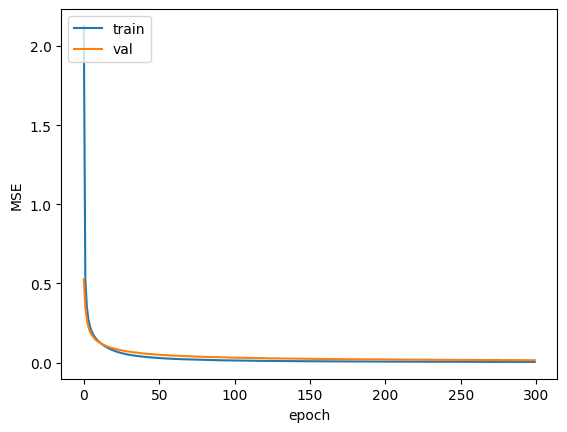

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history["mse"])
plt.plot(history.history["val_mse"])
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

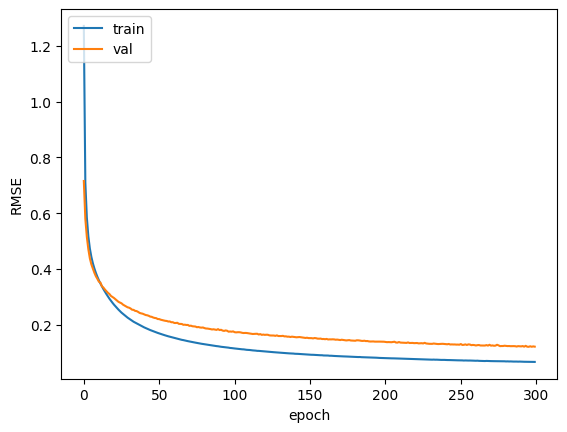

In [21]:
plt.plot(history.history["rmse"])
plt.plot(history.history["val_rmse"])
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
y_pred_tide = model.predict(x_test)

2677/2677 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [23]:
y_pred_filter = []
futures = []

for s in x_test:
    futures.append(filter_method_ray.remote(s.reshape(-1), 125))

results = ray.get(futures)
y_pred_filter.extend(results)

2024-10-04 20:02:40,681	INFO worker.py:1783 -- Started a local Ray instance.


In [24]:
np.array(y_pred_filter).shape

(85662, 1250)

In [25]:
y_test.shape

(85662, 1, 1250)

# Comparing results

In [26]:
y_pred_tide = y_pred_tide.reshape(-1, 1250)
y_test = y_test.reshape(-1, 1250)

# Now perform the RMSE and MAE calculations using NumPy
rmse_per_signal = np.sqrt(np.mean((y_test - y_pred_tide) ** 2, axis=1))  # RMSE for each signal
mae_per_signal = np.mean(np.abs(y_test - y_pred_tide), axis=1)  # MAE for each signal

# Calculate mean and standard deviation for RMSE and MAE
mean_rmse = np.mean(rmse_per_signal)
std_rmse = np.std(rmse_per_signal)

mean_mae = np.mean(mae_per_signal)
std_mae = np.std(mae_per_signal)

# Print the results
print(f"Mean RMSE: {mean_rmse}, Std RMSE: {std_rmse}")
print(f"Mean MAE: {mean_mae}, Std MAE: {std_mae}")

Mean RMSE: 0.07290535074825845, Std RMSE: 0.09810439739033737
Mean MAE: 0.05409980614863042, Std MAE: 0.078080770224256


In [27]:
# Now perform the RMSE and MAE calculations using NumPy
rmse_per_signal = np.sqrt(np.mean((y_test - y_pred_filter) ** 2, axis=1))  # RMSE for each signal
mae_per_signal = np.mean(np.abs(y_test- y_pred_filter), axis=1)  # MAE for each signal

# Calculate mean and standard deviation for RMSE and MAE
mean_rmse = np.mean(rmse_per_signal)
std_rmse = np.std(rmse_per_signal)

mean_mae = np.mean(mae_per_signal)
std_mae = np.std(mae_per_signal)

# Print the results
print(f"Mean RMSE: {mean_rmse}, Std RMSE: {std_rmse}")
print(f"Mean MAE: {mean_mae}, Std MAE: {std_mae}")

Mean RMSE: 0.3342114668012659, Std RMSE: 0.8745948347586635
Mean MAE: 0.18049802014733154, Std MAE: 0.45536458852362177


In [188]:
i = 12
print(signals_annot[i])
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1250)), y=filtered_signals[i], mode='lines', name='Sine Wave'))
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1250)), y=noisy_signals[i], mode='lines', name='Sine Wave'))
fig.show()

[(0, 549, 1, 9), (550, 854, 1, 0), (855, 1138, 1, 8), (1139, 1249, 1, 10)]


In [38]:
y_pred_tide[i].shape

(1, 1250)

In [39]:
rmse_differences = []

# Iterate over the signals and calculate the RMSE difference
for i in range(len(y_test)):
    rmse_tide = rmse(y_test[i], y_pred_tide[i])
    rmse_filter = rmse(y_test[i], y_pred_filter[i])
    rmse_differences.append(rmse_tide - rmse_filter)

# Get the sorted array indices based on the rmse differences
sorted_indices = np.argsort(rmse_differences)

In [99]:
i = sorted_indices[20000]
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1250)), y=x_test[i].reshape(-1), mode='lines', name='Sine Wave'))
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1250)), y=y_test[i].reshape(-1), mode='lines', name='Sine Wave'))
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1250)), y=y_pred_filter[i], mode='lines', name='Sine Wave'))
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1250)), y=y_pred_tide[i].reshape(-1), mode='lines', name='Sine Wave'))
fig.show()

In [104]:
import plotly.graph_objects as go

# Select the index
i = sorted_indices[20000]

# Plot for x_test[i]
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(1250)), 
    y=x_test[i].reshape(-1), 
    mode='lines', 
    name='x_test Signal', 
    line=dict(color='red')  # Set color for this signal
))

# Restore default background
fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show()

# Plot for y_test[i]
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(1250)), 
    y=y_test[i].reshape(-1), 
    mode='lines', 
    name='y_test Signal', 
    line=dict(color='green')  # Set color for this signal
))

# Restore default background
fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show()

# Plot for y_pred_filter[i]
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(1250)), 
    y=y_pred_filter[i], 
    mode='lines', 
    name='y_pred_filter Signal', 
    line=dict(color='blue')  # Set color for this signal
))

# Restore default background
fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show()

# Plot for y_pred_tide[i]
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(1250)), 
    y=y_pred_tide[i].reshape(-1), 
    mode='lines', 
    name='y_pred_tide Signal', 
    line=dict(color='orange')  # Set color for this signal
))

# Restore default background
fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show()


: 